# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

## Problem statement: 
To create a deep learning model that can explain the content of an image in the form of speech through caption generation with the attention mechanism on the Flickr8K data set

This type of model is a use case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text-to-speech library.

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by the CNN-based encoder, and this will be decoded by an RNN model.

In [1]:
#Import all the required libraries

#System libraries
import os, time
from tqdm import tqdm
import glob

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter

# Model building 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Read/Display  images
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model


In [2]:
print("Tensorflow Version:",tf.__version__)
print("Keras Version     :",keras.__version__)

Tensorflow Version: 2.4.1
Keras Version     : 2.4.0


In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

project_folder='/content/gdrive/MyDrive/DataSets/Project_data'

Mounted at /content/gdrive


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable

## Global Variables
INPUT_PATH = "/content/gdrive/MyDrive/DataScience/Eye-For-Blind/Dataset/"
IMAGE_PATH = INPUT_PATH+'Images/'
CAPTIONS_FILE = INPUT_PATH+'captions.txt'
OUTPUT_IMAGE_PATH = "/content/gdrive/MyDrive/DataScience/Eye-For-Blind/Output/Image/"

all_imgs = glob.glob(IMAGE_PATH + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
# function to plot read and plot images
def plot_image(images, caption = None, cmap = None):
    f, axes = plt.subplots(1, len(images), sharey = True)
    f.set_figwidth(15)
    
    for ax, image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

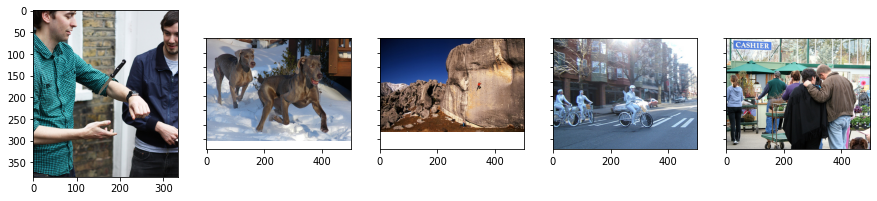

In [6]:
#Visualise both the images & text present in the dataset
plot_image(all_imgs[0:5])

In [7]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
    
    file = open(filename)
    text = file.read()
    file.close()
   
    return text

doc = load_doc(CAPTIONS_FILE)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(IMAGE_PATH+'/'+im_id)
    return keys,key_paths, values

In [9]:
all_img_id, all_img_vector, annotations = get_img_ids_and_captions(doc)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

ID  ...                                           Captions
0  1000268201_693b08cb0e.jpg  ...  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg  ...   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  ...  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  ...  A little girl in a pink dress going into a woo...

[5 rows x 3 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [11]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

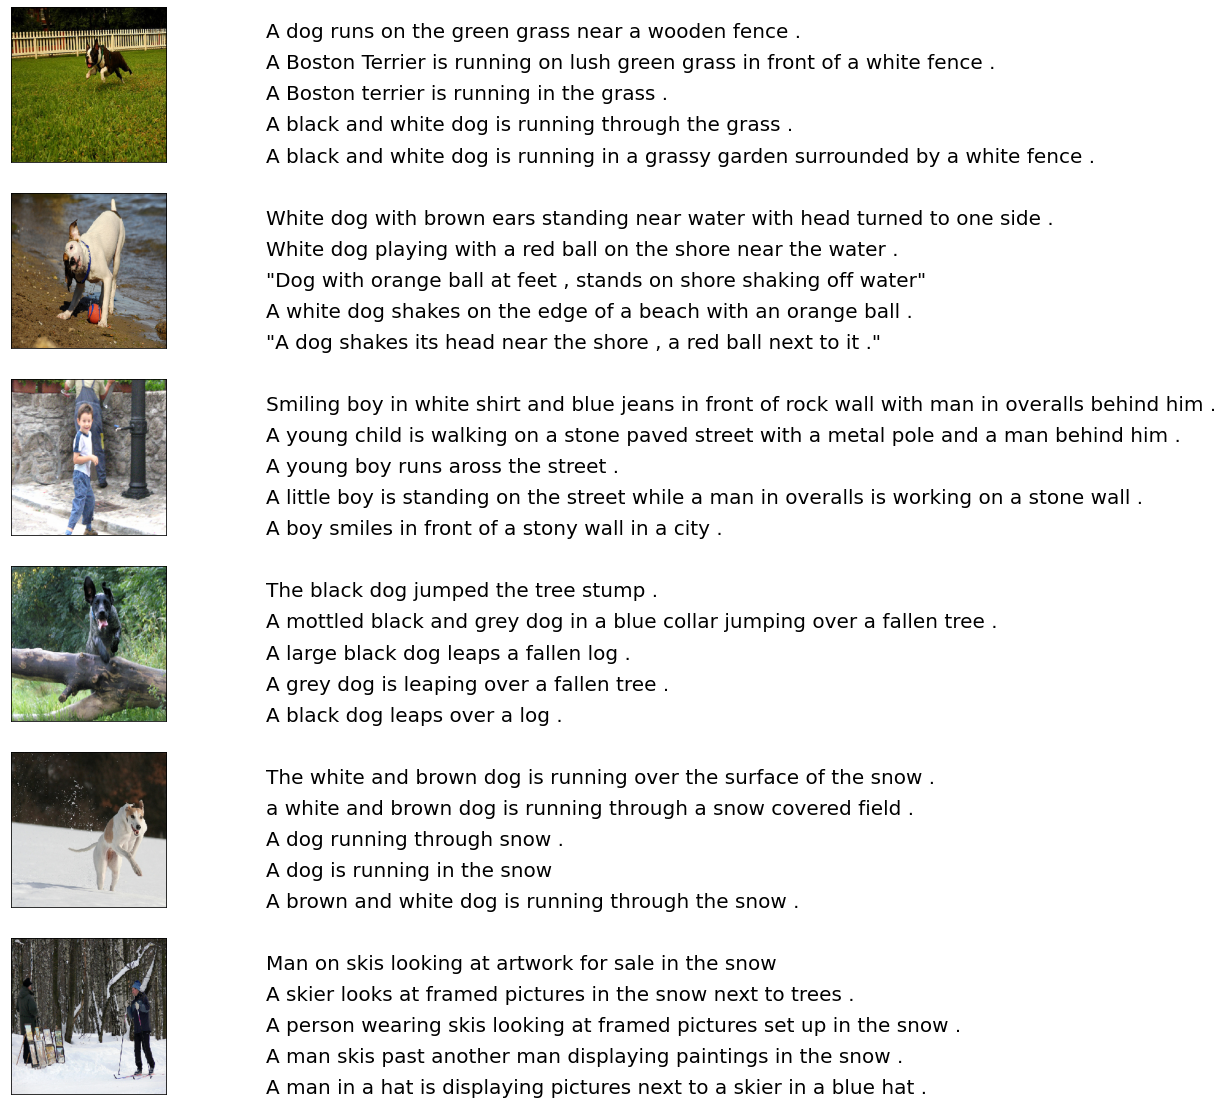

In [12]:
# Images 
fig = plt.figure(figsize=(10,20))
count = 1
    
for Path in df[30:60].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,6)
    count +=2
plt.show()

In [13]:
print("The number of unique file names : {}".format(len(np.unique(df.ID.values))))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [14]:
#Create a list which contains all the captions
annotations = df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>") #add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [15]:
#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out

vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [16]:
#Visualise the top 30 occuring words in the captions
most_occur = val_count.most_common(30)
print(most_occur)

[('a', 40271), ('.', 34212), ('A', 21481), ('in', 18961), ('the', 15328), ('on', 10729), ('is', 9345), ('and', 8850), ('dog', 7982), ('with', 7760), ('man', 6828), ('of', 6712), ('Two', 3962), ('white', 3875), ('black', 3696), ('are', 3503), ('boy', 3442), ('woman', 3227), ('girl', 3217), (',', 3210), ('to', 3173), ('wearing', 3061), ('The', 2920), ('at', 2904), ('water', 2774), ('red', 2660), ('brown', 2475), ('people', 2442), ('young', 2431), ('."', 2365)]


In [17]:
df_word = pd.DataFrame.from_dict(val_count, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

df_word.head()

word  count
0    a  40271
1    .  34212
2    A  21481
3   in  18961
4  the  15328

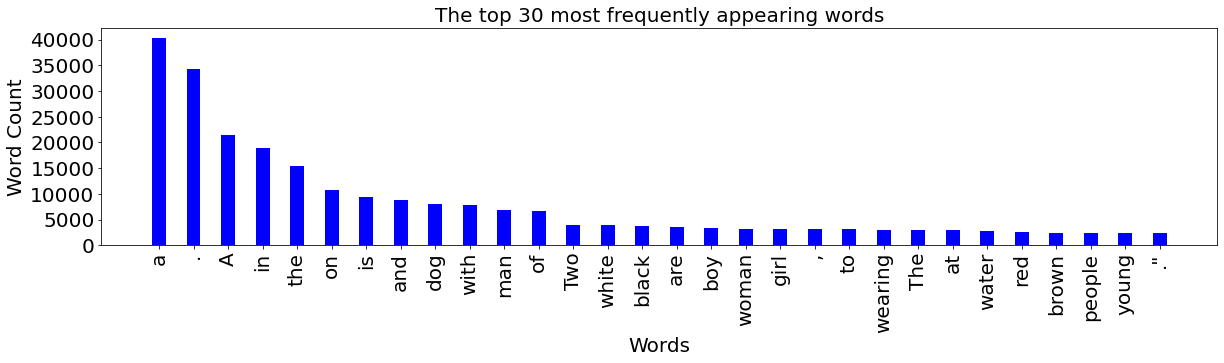

In [18]:
#Visualise the top 30 occuring words in the captions
def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,4))
    plt.bar(words,count,color='blue', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Word Count",rotation=90,fontsize=20) 
    plt.yticks(fontsize=20)
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [19]:
# create the tokenizer
top_word_cnt = 5000
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,
                                                  oov_token="<unk>",
                                                  filters=special_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [20]:
train_seqs[0:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [21]:
annotations[0:5]

0    <start> A child in a pink dress is climbing up...
1    <start> A girl going into a wooden building . ...
2    <start> A little girl climbing into a wooden p...
3    <start> A little girl climbing the stairs to h...
4    <start> A little girl in a pink dress going in...
Name: Captions, dtype: object

In [22]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [23]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

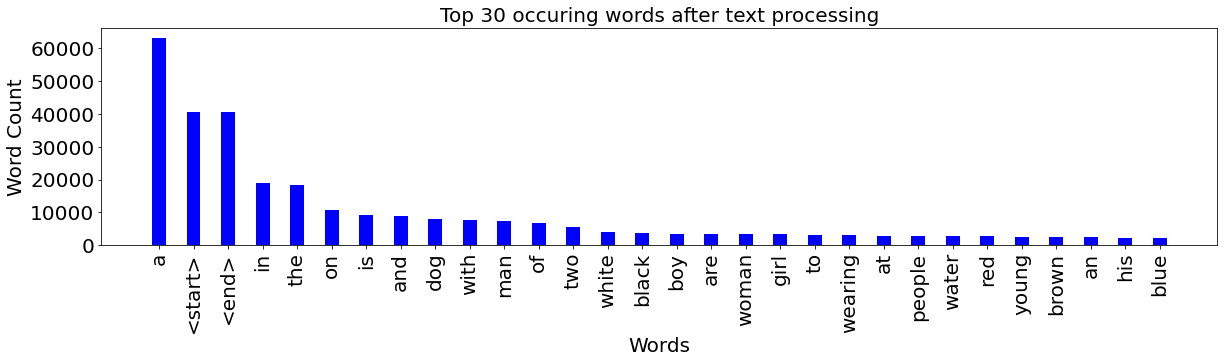

In [24]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_counts = tokenizer.word_counts
df_word = pd.DataFrame.from_dict(word_counts, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

words = list(df_word[:30].word)
count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count, title='Top 30 occuring words after text processing')

In [25]:
max_len = max([len(cap) for cap in train_seqs])
print("shape of caption vector: ", len(train_seqs))
print("Maximum length of sequence: ",max_len)

shape of caption vector:  40455
Maximum length of sequence:  39


In [26]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                          padding='post',
                                                          maxlen=max_len)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [27]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [28]:
#write your code here
def preprocess_image(image_path, shape = (299, 299)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


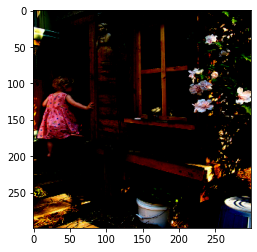

In [29]:
print("Shape after resize :", preprocess_image(all_img_path[0])[0].shape)
plt.imshow(preprocess_image(all_img_path[0])[0])

In [30]:
encode_train_set = sorted(set(all_img_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [31]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  # get the input of the image_model
hidden_layer = image_model.layers[-1].output  # get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer)  # build the final model using both input & output layer

In [32]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
keras.utils.plot_model(image_features_extract_model, "final_model.png", show_shapes=True)

In [34]:
# write your code to extract features from each image in the dataset
feature_dict = {}
for image,path in tqdm(image_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [01:05<00:00,  3.87it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
# train-test split
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,cap_vector,
                                                                        test_size=0.2,random_state=42)

In [36]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [37]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [38]:
def generate_dataset(images_data, captions_data, BATCH_SIZE =32, BUFFER_SIZE = 1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [39]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [40]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


In [41]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [42]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

## Encoder

In [43]:

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        
        return features

In [44]:
encoder=Encoder(embedding_dim)

### Attention model

In [45]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [46]:

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask = mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [47]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [48]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [49]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [50]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [51]:
checkpoint_path = "/content/gdrive/MyDrive/DataScience/Eye-For-Blind/checkpoints/train/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [54]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [55]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [56]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.189, & test loss is 1.010
Time taken for 1 epoch 250.42227292060852 sec

Test loss has been reduced from 100.000 to 1.010


  7%|▋         | 1/15 [04:11<58:35, 251.08s/it]

For epoch: 2, the train loss is 0.938, & test loss is 0.899
Time taken for 1 epoch 134.26421546936035 sec

Test loss has been reduced from 1.010 to 0.899


 13%|█▎        | 2/15 [06:25<46:50, 216.17s/it]

For epoch: 3, the train loss is 0.855, & test loss is 0.830
Time taken for 1 epoch 134.61300110816956 sec

Test loss has been reduced from 0.899 to 0.830


 20%|██        | 3/15 [08:41<38:22, 191.89s/it]

For epoch: 4, the train loss is 0.795, & test loss is 0.777
Time taken for 1 epoch 134.62294912338257 sec

Test loss has been reduced from 0.830 to 0.777


 27%|██▋       | 4/15 [10:56<32:03, 174.84s/it]

For epoch: 5, the train loss is 0.746, & test loss is 0.729
Time taken for 1 epoch 134.40946245193481 sec

Test loss has been reduced from 0.777 to 0.729


 33%|███▎      | 5/15 [13:11<27:08, 162.90s/it]

For epoch: 6, the train loss is 0.703, & test loss is 0.687
Time taken for 1 epoch 134.5348415374756 sec

Test loss has been reduced from 0.729 to 0.687


 40%|████      | 6/15 [15:26<23:10, 154.51s/it]

For epoch: 7, the train loss is 0.663, & test loss is 0.650
Time taken for 1 epoch 134.70926189422607 sec

Test loss has been reduced from 0.687 to 0.650


 47%|████▋     | 7/15 [17:41<19:49, 148.74s/it]

For epoch: 8, the train loss is 0.628, & test loss is 0.616
Time taken for 1 epoch 134.6447947025299 sec

Test loss has been reduced from 0.650 to 0.616


 53%|█████▎    | 8/15 [19:56<16:52, 144.62s/it]

For epoch: 9, the train loss is 0.595, & test loss is 0.583
Time taken for 1 epoch 134.85994672775269 sec

Test loss has been reduced from 0.616 to 0.583


 60%|██████    | 9/15 [22:11<14:11, 141.84s/it]

For epoch: 10, the train loss is 0.564, & test loss is 0.556
Time taken for 1 epoch 134.3452262878418 sec

Test loss has been reduced from 0.583 to 0.556


 67%|██████▋   | 10/15 [24:26<11:38, 139.71s/it]

For epoch: 11, the train loss is 0.537, & test loss is 0.529
Time taken for 1 epoch 134.57879257202148 sec

Test loss has been reduced from 0.556 to 0.529


 73%|███████▎  | 11/15 [26:41<09:13, 138.34s/it]

For epoch: 12, the train loss is 0.511, & test loss is 0.503
Time taken for 1 epoch 134.60361075401306 sec

Test loss has been reduced from 0.529 to 0.503


 80%|████████  | 12/15 [28:56<06:51, 137.32s/it]

For epoch: 13, the train loss is 0.489, & test loss is 0.480
Time taken for 1 epoch 133.32070589065552 sec

Test loss has been reduced from 0.503 to 0.480


 87%|████████▋ | 13/15 [31:10<04:32, 136.27s/it]

For epoch: 14, the train loss is 0.468, & test loss is 0.461
Time taken for 1 epoch 131.6536991596222 sec

Test loss has been reduced from 0.480 to 0.461


 93%|█████████▎| 14/15 [33:22<02:14, 134.99s/it]

For epoch: 15, the train loss is 0.449, & test loss is 0.443
Time taken for 1 epoch 132.0500946044922 sec

Test loss has been reduced from 0.461 to 0.443


100%|██████████| 15/15 [35:34<00:00, 142.33s/it]


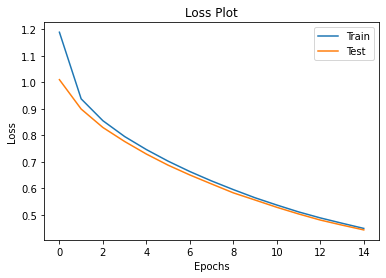

In [57]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(["Train", "Test"], loc ="best")
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [58]:
def greedy_evaluate(image):
    max_length=max_len
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [59]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_len
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [60]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [61]:
from nltk.translate.bleu_score import sentence_bleu

In [62]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [63]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

Real Caption      : a man in a jersey stands in front of a large crowd
Prediction Caption: a man in a green jersey is being carried



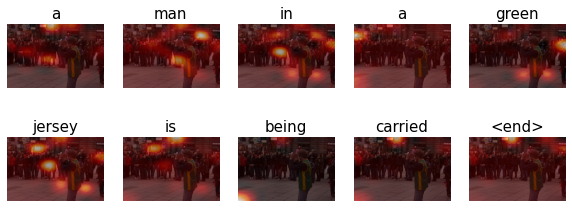

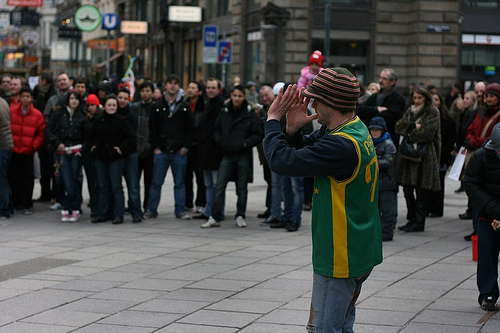

In [64]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = greedy_evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [65]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

Real Caption      : a man in a jersey stands in front of a large crowd
Prediction Caption: a man in a green jersey is being carried

BELU score: 
Individual 1-gram: 39.80729503187718
Individual 2-gram: 26.8699241465171
Individual 3-gram: 20.472323159251122
Individual 4-gram: 11.942188509563156


In [66]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

BELU score: 
Cumumlative 1-gram: 39.80729503187718
Cumumlative 2-gram: 32.705030163333696
Cumumlative 3-gram: 28.241197613608186
Cumumlative 4-gram: 22.613617379612148


In [67]:
captions=beam_evaluate(test_image)
print(captions)

a red jersey rain in line crowd


In [68]:
# install required library
!pip install gTTS

In [69]:
# converting text-to-speach 
from gtts import gTTS
from IPython import display

tts = gTTS(pred_caption, slow = False)
tts.save('/content/gdrive/MyDrive/DataScience/Eye-For-Blind/pred_caption.mp3')

sound_file = '/content/gdrive/MyDrive/DataScience/Eye-For-Blind/pred_caption.mp3'
display.display(display.Audio(sound_file))

In [70]:
# converting text-to-speach using beam_search
tts = gTTS(captions, slow = False)
tts.save('/content/gdrive/MyDrive/DataScience/Eye-For-Blind/beam_evaluate.mp3')

sound_file = '/content/gdrive/MyDrive/DataScience/Eye-For-Blind/beam_evaluate.mp3'
display.display(display.Audio(sound_file))